# Analyzing heavy traffic indicators on I-94

In this project, we're going to analyze a datset about the traffic on the I-94 Interstate highway, which connects the Great Lakes and northern Great Plain regions of the United States, running from Michigan to Montana.

Our goal is to find some indicators of heavy traffic on I-94 by using traffic volume data made available by John Hogue, you can find the original dataset and the data dictionary on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

The documentation mentions that a station located midway between Minneapolis and Saint Paul recorded this traffic data, recording only cars moving from east to west. This means our analysis will be about westbound traffic nearby this station and we'll avoid generalizing our results for the entire I-94 highway.

In [1]:
import pandas as pd
traffic=pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


The data has 48,204 rows each representing an hourly observation, made up of  9 variables with no null values. We have data from 2012-10-02 09:00:00 until 2018-09-30 23:00:00

### Analyzing traffic volume

We're going to start our analysis by examining the distribution of the `traffic_volume` column.

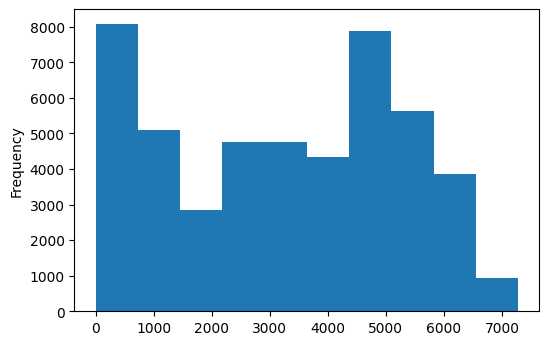

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

traffic['traffic_volume'].plot.hist()

In [5]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Between october 2nd, 2012 and september 30th, 2018, the volume of cars ranged from 0 to 7,280 cars.
About 25% of the time the traffic volume was made up of 1,193 cars or less, probably during nighttime. About 25% of the time this value was four times larger, with 4,933 cars or more on the road.

Assuming that nighttime or dayttime influences traffic sounds like a reasonable approach, let´s divide our dataset in two parts:
* Daytime data: hours 7 a.m to 7 p.m.
* Nighttime data: hours from 7 p.m. to 7 a.m.

In [6]:
traffic['date_time']=pd.to_datetime(traffic['date_time'])

daytime=traffic[(traffic['date_time'].dt.hour>=7) &
                (traffic['date_time'].dt.hour <19)]

nighttime=traffic[(traffic['date_time'].dt.hour>=19) |
                (traffic['date_time'].dt.hour <7)]

We're going to look at its histograms and compare the traffic volume at night and during the day

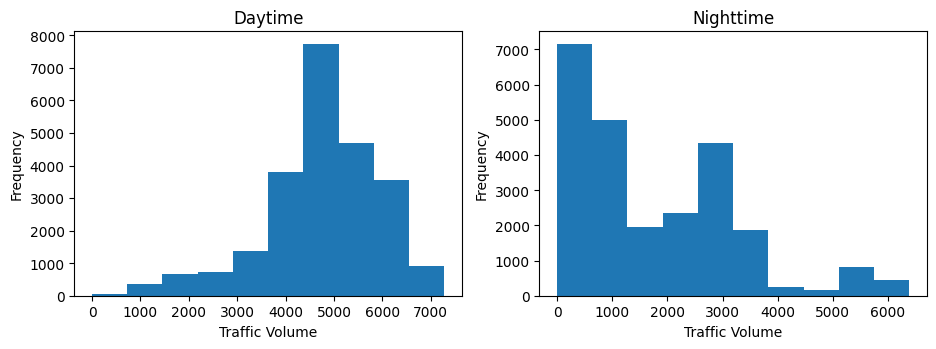

In [7]:
plt.figure(figsize=(11,3.5))

plt.subplot(1,2,1)
daytime['traffic_volume'].plot.hist()
plt.title('Daytime')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
nighttime['traffic_volume'].plot.hist()
plt.title('Nighttime')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')

plt.show()

In [8]:
daytime['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [9]:
nighttime['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

From our histogram and the statistics of traffic volume, we can see a couple of differences.

* The histogram for daytime has a left skew which means most of its traffic volumes values are high compared to the nighttime histogram, which has a right skew, with a heavy concentration on lower car volumes.
* The average volume for daytime is almost 2.7 times the average volume for nighttime
* 75% of the time, nighttime values fall under 2,819 cars compared to the 5,559 cars for daytime
* Interestingly both have a similar max volume and a minimum of zero cars passing by in some hours

As we can see nighttime has less volume of cars and less to no traffic compared to nighttime, as our goal in this project is to find the indicators of heavy traffic, we're going to focus on the daytime data.

### Daytime traffic volume by month

Another possible indicator of heavy traffic is time, there could be more cars on a certain month, day or time of the day.

We're going to generate line plots to show the traffic volume changed according to:
* Month
* Day of the week
* Time of day

In [10]:
daytime['month'] = daytime['date_time'].dt.month
by_month = daytime.groupby('month').mean()
by_month['traffic_volume']

<ipython-input-10-7d784f045492>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

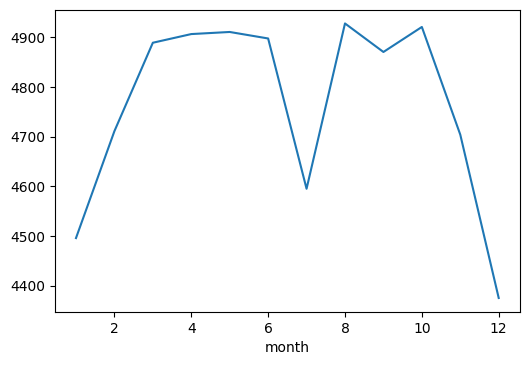

In [11]:
by_month['traffic_volume'].plot()

We can see from the plot that the traffic volume is reduced in the colder months of (November to February) and it peaks on hotter months (March to October), interestingly July has a notable decrease.

### Daytime traffic by day of the week

Now, let's look at the plot for each day of the week, remember that zero represents Monday and 6 is Sunday.

In [12]:
daytime['dayofweek'] = daytime['date_time'].dt.dayofweek
by_dayofweek = daytime.groupby('dayofweek').mean()
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday

<ipython-input-12-88ced10f3bb7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

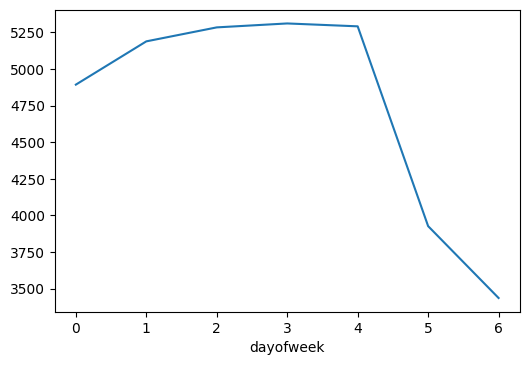

In [13]:
by_dayofweek['traffic_volume'].plot()

The average traffic volume is significantly heavier from Monday to Friday, with a noticeable decrease on Saturday and Sunday, with values below 4,000 cars.

### Daytime traffic by hour of the day

Next, we'll generate a line plot for the time of day. The average values of the weekend would drag the average volume down, so we're going to calculate the average traffic volume of the weekend separetely from the business days.

In [14]:
daytime['hour'] = daytime['date_time'].dt.hour
bussiness_days = daytime.copy()[daytime['dayofweek'] <= 4] # 4 == Friday
weekend = daytime.copy()[daytime['dayofweek'] >= 5] # 5 == Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

print(by_hour_business['traffic_volume'])
print(by_hour_weekend['traffic_volume'])

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64
hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64


<ipython-input-14-f8473ede9f01>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



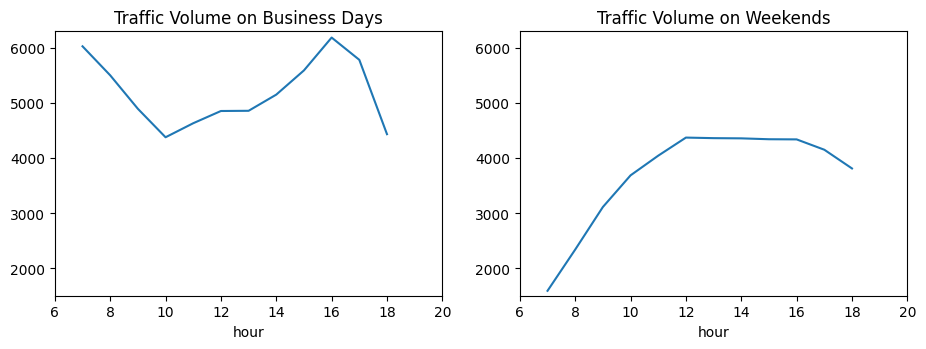

In [18]:
plt. figure(figsize=(11,3.5))

plt.subplot(1,2,1)
by_hour_business['traffic_volume'].plot.line()
plt.xlim(6,20)
plt.ylim(1500,6300)
plt.title('Traffic Volume on Business Days')

plt.subplot(1,2,2)
by_hour_weekend['traffic_volume'].plot()
plt.xlim(6,20)
plt.ylim(1500,6300)
plt.title('Traffic Volume on Weekends')

plt.show()

During business days the lowest average volume is at 10AM with a volume of 4,378 cars, the highest volume of traffic is around 7AM and 16PM, which could be due to people going to and from the office.
In comparison, the highest average traffic volume on the weekends is less than the lowest volume on business days.

As we've seen, time is a big factor on the volume of traffic, colder months have less traffic than hotter months, business days are busier than weekends and the rush hours are around 7AM and 16PM.

### Impact of weather on traffic volume

Another possible indicator of heavy traffic is the weather. The dataset contains six columns related to weather:
* `temp`
* `rain_1h`
* `snow_1h`
* `clouds_all`
* `weather_main`
* `weather_description`

Some of these columns are numericla, let's start by looking how they are correlated with `traffic_volume`.

In [20]:
daytime.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

The temperature column shows the highest correlation with the traffic volume with a value of .13, the rest of the weather columns don't seem to have strong correlations with the traffic volume.

Let's generate a scatter plot to visualize this correlation.

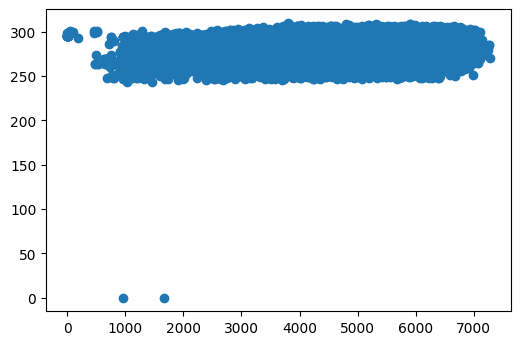

In [21]:
plt.scatter(daytime['traffic_volume'],daytime['temp'])

Aside from the fact that there seem to be two wrong temperatures of 0K, temperature doesn't seem to really impact traffic volume.

### Weather types

Let's look at the categorical weather columns `weather_main` and `weather_description`, by calculating the average traffic volume associated with each unique value.

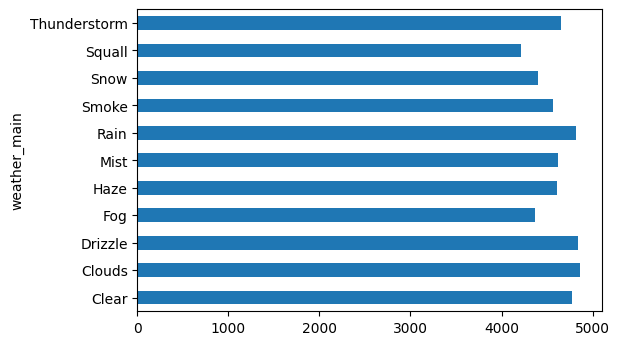

In [32]:
by_weather_main = daytime.groupby('weather_main').mean()
by_weather_main['traffic_volume'].plot.barh()

There doesn't seem to be a weather type that is significantly higher than the rest, and the average traffic volume for all weather types is lower than 5,000.

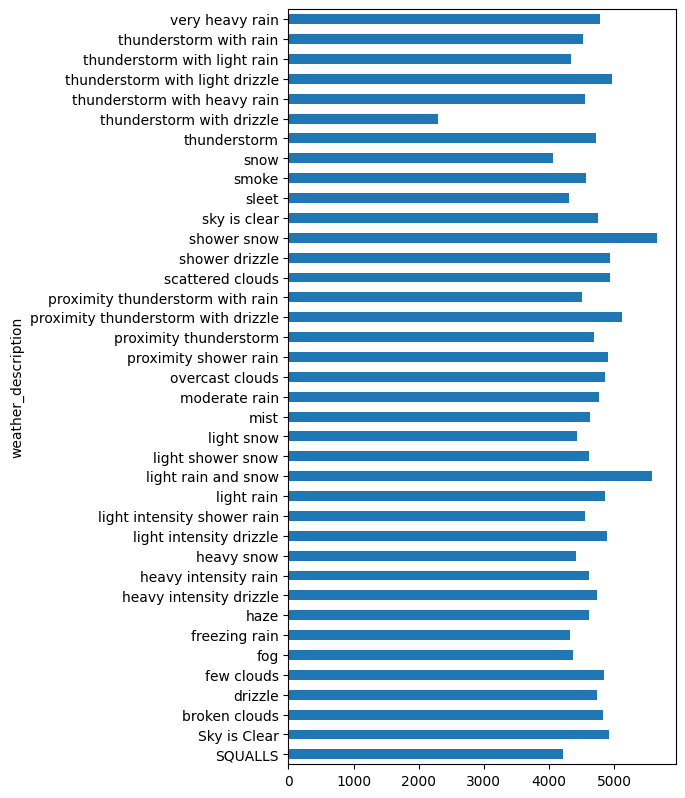

In [34]:
by_weather_description = daytime.groupby('weather_description').mean()
by_weather_description['traffic_volume'].plot.barh(figsize=(5,10))

The following weather descriptions have an average volume higher than 5,000 cars:

* Shower snow
* Light rain and snow
* Proximity thunderstorm with drizzle

It's unclear why this weather is affecting traffic volume, considering worse weather conditions don't seem to have a bigger impact.

### Conclusion

The biggest of indicator of heavy traffic found during this analysis is time, there's a higher traffic volume:
* During warm months from March to October
* On Business days
* During business days, the rush hours are at around 7AM and 16PM

Weather seems to be another indicator for the following weather descriptions:

* Shower snow
* Light rain and snow
* Proximity thunderstorm with drizzle
